# Perceptual loss - Style transfer in a single forward pass

Paper: https://arxiv.org/abs/1603.08155


Idea: Train a transformation network which transforms an input image X into an image X' in the style of a style image S using a single forward pass, without having to solve an optimization problem for each style transfer.

To compute the loss, use a pretrained model which assesses the perceptual quality of the generated image. This essentially evaluates the model in the feature space.



In [ ]:
# Colab stuff

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.layers import Input
from IPython.display import Image, display
from keras.models import load_model

from PIL import Image as ImagePIL
import matplotlib.pyplot as plt
import seaborn as sb

Init Plugin
Init Graph Optimizer
Init Kernel


# Image preprocessing

Images in:
- Input image X -> image we want to transform
- Content image C -> Image from which we want the content. Isn't that X for style transfer??
- Style image S -> Image which contains the style we want to extract.
  

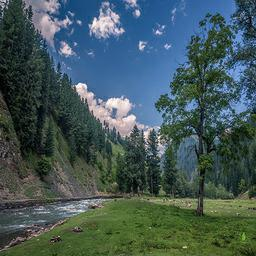

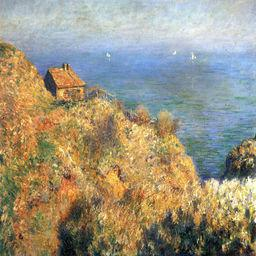

In [3]:
# Load images
# Style images
content_images = ["0cae98323f", ""]
style_images = ["732d76a469", "853f8d711f"]

content_image = content_images[0]
style_image = style_images[1]

base_path_content = "../../data/art/photo_jpg/"
base_path_style = "../../data/art/monet_jpg/"
content_image_path = base_path_content + content_image + ".jpg"
style_image_path = base_path_style + style_image + ".jpg"
display(Image(content_image_path))
display(Image(style_image_path))

In [5]:
# Make tf dataset from content images.
image_size = (256,256)
batch_size = 4

base_path_content = "../../data/art/photo_jpg/"
base_path_content = "../../data/art/testLarge/"

#content_image_path = base_path_content + content_image + ".jpg"
train = keras.preprocessing.image_dataset_from_directory(
    base_path_content,
    validation_split=0.0,
    #subset="training",
    labels=None,
    seed=1581,
    image_size=image_size,
    batch_size=batch_size
)


Found 24 files belonging to 1 classes.


' validation = keras.preprocessing.image_dataset_from_directory(\n    base_path_content,\n    validation_split=0.2,\n    subset="validation",\n    labels=None,\n    seed=1581,\n    image_size=image_size,\n    batch_size=batch_size\n) '

In [2]:
# Preprocess and postprocess images
def get_and_scale_image(image_path):
    """
    Loads and scales a .jpg image.
    Returns a tf.tensor with batch dimension, scaled to [0,1].
    """

    image = keras.preprocessing.image.load_img(image_path)
    image = keras.preprocessing.image.img_to_array(image)
    
    # Scale
    image = image / 255.0

    # Adds batch dimension. Shape is (batch, height, width, colour)
    image = np.array([image])

    # Convert to tensorflow tensor
    image = tf.convert_to_tensor(image)

    return image


# Define transform and loss networks

## Transform network
Use Keras Functional API to construct network, since we need the residual blocks.

In [3]:
# Create reflection padding layer
class ReflectionPadding2D(keras.layers.Layer):
    def __init__(self):
        super(ReflectionPadding2D, self).__init__()
    
    def call(self, inputs):
        paddings = tf.constant([[0,0],[40,40],[40,40],[0,0]])

        return tf.pad(inputs, paddings, "REFLECT")

# Residual block
def residual_block(n_filters, name, inputs, stride=(1,1)):
    x = layers.Conv2D(filters=n_filters, kernel_size=(3,3), strides=stride, activation="relu", name='Conv1ResidualBlock_' + name)(inputs)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=n_filters, kernel_size=(3,3), strides=stride, name='Conv2ResidualBlock_' + name)(x)
    x = layers.BatchNormalization(scale=False)(x)

    # Crop the input to match sizes and add activations.
    inputs = tf.keras.layers.Cropping2D(cropping=((2,2),(2,2)), data_format=None)(inputs)
    x = layers.Add()([x, inputs])
    return x


# Test
x = tf.ones(shape=(1,84,84,128))
print(x.shape)

y = residual_block(128,"1", x)
print(y.shape)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

(1, 84, 84, 128)
(1, 80, 80, 128)


2021-12-11 11:04:42.112758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-11 11:04:42.112879: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
### Transform network ###
def get_uncompiled_model():
    """
    Loads the transformation network.
    """

    inputs = keras.Input(shape=(256,256,3), name="InputLayer")

    # Reflection padding
    padding = ReflectionPadding2D()
    padding._name = "Reflection"
    x = padding(inputs)
   
    x = layers.Conv2D(filters=32, kernel_size=(9,9),strides=(1,1), activation="relu", padding='same', name="Conv1")(x)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3),strides=(2,2), activation="relu", padding='same', name="Conv2")(x) 
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3,3),strides=(2,2), activation="relu", padding='same', name="Conv3")(x)
    x = layers.BatchNormalization(scale=False)(x)

    # Residual blocks
    x = residual_block(128,"1", x)
    x = residual_block(128,"2", x)
    x = residual_block(128,"3", x)
    x = residual_block(128,"4", x)
    x = residual_block(128,"5", x)

    # Deconvolutions
    x = layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Deconv1")(x)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name='Deconv2')(x)
    x = layers.BatchNormalization(scale=False)(x)

    outputs = layers.Conv2D(filters=3, kernel_size=(9,9), strides=(1,1), activation="tanh", padding='same', name="Conv4")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="Transform_network")

In [80]:
#transform_network.summary()
#keras.utils.plot_model(transform_network, "Transform_network.png", show_shapes=True)

In [9]:
### Smaller test model
def get_test_model():
    inputs = keras.Input(shape=(256,256,3), name="InputLayer")
    
    x = layers.Conv2D(filters=32, kernel_size=(9,9), strides=(1,1), activation="relu", padding='same', name="Conv1")(inputs)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Conv2")(x)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Deconv1")(x)
    x = layers.BatchNormalization(scale=False)(x)

    x = layers.Conv2DTranspose(filters=3, kernel_size=(9,9), strides=(1,1), padding='same', name="Deconv2")(x) 
    outputs = activations.tanh(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="Test_network")

test_model = get_test_model()
#test_model.summary()

## Loss network
Use pretrained VGG16.

In [9]:
# Loss network
# Input: 224x224 -> Do I have to resize the input image from 256x256 or does the model not care?
loss_net = vgg16.VGG16(include_top=False, weights="imagenet", input_tensor=Input(shape=(256,256,3)))
loss_net_outputs = dict([(layer.name, layer.output) for layer in loss_net.layers])

loss_net_activations = keras.Model(inputs=loss_net.inputs, outputs=loss_net_outputs)
#loss_net.summary()

# Define loss function

In [10]:
# Hashtables: layer -> [height, width, channels]

style_layers = {
    "block1_conv2": [256,256,64],
    "block2_conv2": [128,128,128],
    "block3_conv3": [64,64,256],
    "block4_conv3" : [32,32,512]
}
content_layers = {"block3_conv3": [64,64,256]}

In [15]:
# Feature loss (content loss)

# Define input image shape
channels = 3
height = 256
width = 256

# TODO: Add batch size
def compute_content_loss(generated, content, dimensions):
    """
    Computes the content loss from the given features.
    Equation 2 in paper.

    Args:
    generated:  Tensor feature map of the generated image.
    content:    Tensor feature map of the content image.
    dimensions: List of layer dimensions [height, width, channels]
    """
    # Check dimensions
    assert generated.shape[0] == content.shape[0], "Batch dimensions of generated and content image don't match!"

    height, width, channels = dimensions[0], dimensions[1], dimensions[2]
    scaling_factor = (int(height/4) * int(width/4) * channels) # H, W, C

    # Sum over all elements, including the batch_size to get average loss over the batch.
    content_reconstruction_loss =  tf.math.reduce_sum(tf.square(generated - content)) / (scaling_factor * generated.shape[0])
    return content_reconstruction_loss


def gram_matrix(x):
    """
    Computes the gram matrix with batch dimension.
    
    y = xT * x

    Inputs:
    x  -- tf.tensor with batch dimension (batch_dim, x1, x2, x3)
    """
    x = tf.transpose(x, (0,3,1,2))
    features = tf.reshape(x, (tf.shape(x)[0], tf.shape(x)[1], -1))
    gram = tf.matmul(features, tf.transpose(features, (0,2,1)))
    return gram


# TODO: Add batch size
def compute_style_loss(generated, style, dimensions):
    """
    Compute style loss for one layer.
    """
    
    # Dimensions
    height, width, channels = dimensions[0], dimensions[1], dimensions[2] 
    scaling_factor = (channels * height * width)**2
    generated = gram_matrix(generated)
    style = gram_matrix(style)

    # Compute the total average loss over all elements in the batch.
    res = tf.reduce_sum(tf.square(generated - style)) / (scaling_factor * generated.shape[0])
    return res


### TEST: Gram matrix
x1 = tf.ones(shape=(1,2,2,3)) * 2
x2 = tf.ones(shape=(1,2,2,3)) * 3
x = tf.concat([x1, x2], 0)
y = gram_matrix(x)


In [16]:
# TODO: Add weights? See paper page 4
def compute_perceptual_loss(generated_image, content_image, style_image):
    """
    Computes the loss with the loss network.

    Args:
    tf.tensors, scaled to [0,1] with dim (b,h,w,c), RGB.
    """
    
    # Combine input tensors to make one pass with all in parallel.
    input_tensors = tf.concat([generated_image, content_image, style_image], axis=0)

    # Preprocess input_tensors for vgg16. Expects range [0, 255]
    input_tensors = tf.keras.applications.vgg16.preprocess_input(input_tensors*255)

    # Forward pass to get loss from loss network.
    features = loss_net_activations(input_tensors, training=False)

    # Initialize loss
    loss = tf.zeros(shape=())

    # Compute content loss
    for content_layer in content_layers.keys():
        layer_features = features[content_layer]
        generated_features = layer_features[0:batch_size,:,:,:]
        content_features = layer_features[batch_size:batch_size*2,:,:,:]
        loss += compute_content_loss(generated_features, content_features, content_layers[content_layer])

    # Compute style loss
    for style_layer in style_layers.keys():
        layer_features = features[style_layer]
        generated_features = layer_features[0:batch_size,:,:,:]
        style_features = layer_features[2*batch_size,:,:,:]
        style_features = tf.expand_dims(style_features, 0)
        loss += compute_style_loss(generated_features, style_features, style_layers[style_layer])

    return loss

In [14]:
# Pixel loss
def compute_pixel_loss(generated_image, content_image, style_image):
    #print(tf.math.reduce_min(content_image), tf.math.reduce_max(content_image))
    #print(tf.math.reduce_min(generated_image), tf.math.reduce_max(generated_image))
    for img in content_image:
        print(tf.math.reduce_min(img), tf.math.reduce_max(img))
        break
    return tf.reduce_sum(tf.square(content_image - generated_image))


In [36]:
# Uninitialized models
transform_network = get_uncompiled_model()
#transform_network = get_test_model()

# Load weights
transform_network.load_weights("models/732d76a469_epochs700_batchSize2_testLarge")


@tf.function
def compute_loss_and_grads(content_image, style_image):
    """
    Takes in content and style images as tf.tensors with batch dimension
    and scaled to range [0,1].
    """
    
    with tf.GradientTape() as tape:

        # Forward pass
        generated_image = transform_network(content_image, training=True)
        
        # Convert to range [0,1]
        generated_image = ((generated_image * 0.5) + 0.5)

        # Get loss
        loss = compute_perceptual_loss(generated_image, content_image, style_image)
        #loss = compute_pixel_loss(generated_image, content_image, style_image)

    # Get gradients and upate weights
    grads = tape.gradient(loss, transform_network.trainable_weights)
    optimizer.apply_gradients(zip(grads, transform_network.trainable_weights))
    return loss

2021-12-11 11:15:31.685490: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open models/732d76a469_epochs700_batchSize2_testLarge: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## Build training loop


In [ ]:
#### AUTOMATED  LOOP
save_epochs = [2,4,7]

optimizer = keras.optimizers.Adam(learning_rate=0.001)
epochs = 700 # TOTAL


## Custom training loop from scratch

# Load style image
print("Loading style image...")
style_image_name = "853f8d711f" #"732d76a469"

# Load style image as tf.tensor, scaled.
style_image = get_and_scale_image("../../data/art/monet_jpg/"+style_image_name+".jpg")

for epoch in range(epochs):
    print("Running epoch %d / %d" %(epoch+1, epochs))
    for step, img in enumerate(train):
        
        # Scale image to range [0,1]
        img = img / 255.0

        loss = compute_loss_and_grads(img, style_image)
        
        # Print current batch-wise loss
        if step % 10 == 0:
            print("Current loss for one batch at step {:.0f}: {:.2f}".format(step, loss))
            #transform_network.save_weights("models/latest/ckpt")


    if epoch+1 in save_epochs:
        transform_network.save_weights("models/"+style_image_name+"_epochs" +str(epoch+1) + "_batchSize2" + "_testLarge", save_format='h5')
        print("Saved latest model at epoch", epoch+1)

# Save final model. Format: <style_image>_epochs<numEpochs>_batchSize<numBatchSize>_<dataSet> 
#transform_network.save_weights("models/"+style_image_name+"_epochs10" + "_batchSize1" + "_testLarge", save_format='h5')

## Show results

In [5]:
def show_image(image_name, style=False):
    """
    Displays selected image.
    """
    if style == False:
        base_path = "../../data/art/photo_jpg/"
    else:
        base_path = "../../data/art/monet_jpg/"

    image = keras.preprocessing.image.load_img(base_path + image_name + ".jpg")
    display(image)

In [6]:
def generate_image(image_name, filename=None):
    """
    Runs inference with selected image and displays result.
    """
    
    base_path = "../../data/art/photo_jpg/"

    image = keras.preprocessing.image.load_img(base_path + image_name + ".jpg")  
    image = keras.preprocessing.image.img_to_array(image)
    
    # Scale
    image = image / 255.0

    # Adds batch dimension. Shape is (batch, height, width, colour)
    image = np.array([image])

    # Convert to tensorflow tensor
    image = tf.convert_to_tensor(image)   
    generated_image = transform_network(image, training=False)
    tf.print(tf.math.reduce_min(generated_image), tf.math.reduce_max(generated_image))

    generated_image = generated_image.numpy()
    generated_image = ((generated_image * 0.5) + 0.5) 
    generated_image = generated_image * 255

    # Remove batch dimension
    generated_image = generated_image.reshape((256,256,3))

    print(generated_image.min(), generated_image.max())

    img = ImagePIL.fromarray(np.uint8(generated_image)).convert('RGB')
    display(img)
    if filename != None:
        # Used filenames: <content_image>-<style_image>_batchSize_epochs
        img.save("generatedImages/testLarge/" + filename + ".png")
    return generated_image


### Dataset testLarge

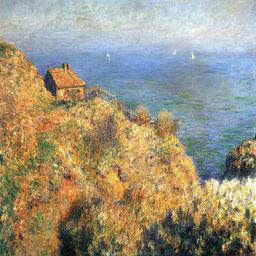

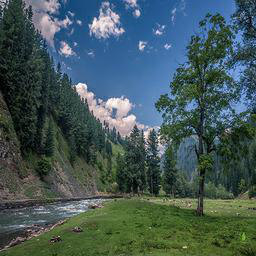

In [7]:
# Style image
show_image("853f8d711f", style=True)

# Content
show_image("0cae98323f")

-0.99954015 0.99982667
0.058630854 254.9779


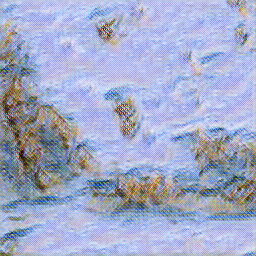

<AxesSubplot:ylabel='Count'>

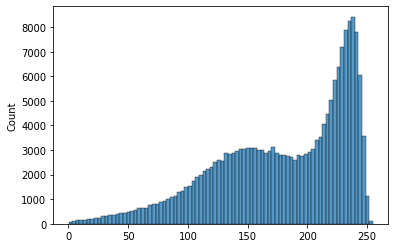

In [37]:
test_image = "0cae98323f"
data = generate_image(test_image, filename="0cae98323f-732d76a469_batchSize2_epochs700")
sb.histplot(data.reshape(-1))

-1 1.00000012
0.0 255.0


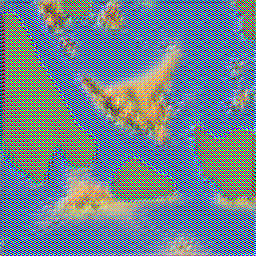

<AxesSubplot:ylabel='Count'>

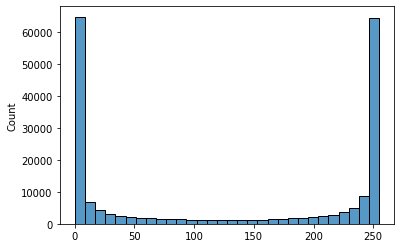

In [66]:
# Style: "853f8d711f" Batchsize: 1 Epochs: 200
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))

-1 1.00000012
0.0 255.0


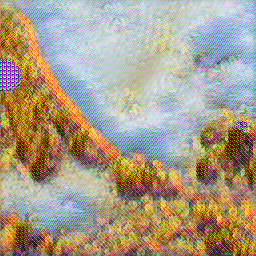

<AxesSubplot:ylabel='Count'>

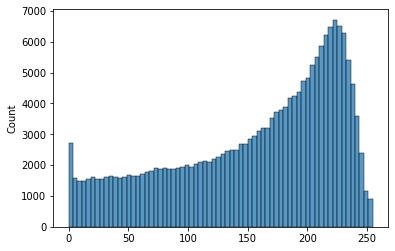

In [16]:
# Style: "853f8d711f" Batchsize: 1 Epochs: 300
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))

-1 1.00000012
0.0 255.0


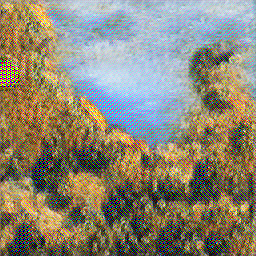

<AxesSubplot:ylabel='Count'>

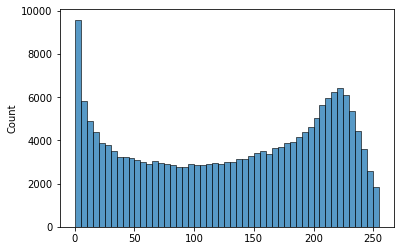

In [18]:
# Style: "853f8d711f" Batchsize: 1 Epochs: 400
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))

-1 1.00000012
0.0 255.0


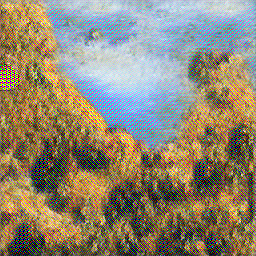

<AxesSubplot:ylabel='Count'>

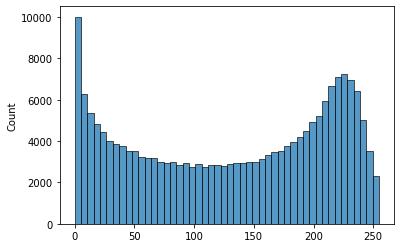

In [20]:
# Style: "853f8d711f" Batchsize: 1 Epochs: 500
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))

-1 1.00000012
0.0 255.0


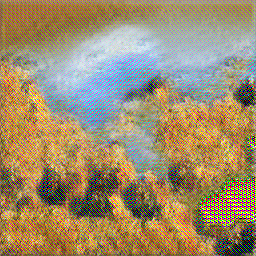

In [22]:
test_image = "1f8b43823c"
data = generate_image(test_image)

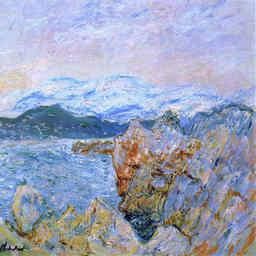

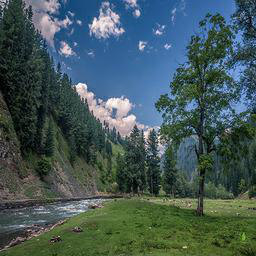

In [64]:
# Style image
show_image("732d76a469", style=True)

# Content
show_image("0cae98323f")

In [ ]:
# Style: "732d76a469" Batchsize: 1 Epochs: 300
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))

In [ ]:
# Style: "732d76a469" Batchsize: 1 Epochs: 400
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))

In [ ]:
# Style: "732d76a469" Batchsize: 1 Epochs: 500
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))